In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import learning_curve


Bad key text.latex.preview in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
warnings.simplefilter('ignore')

In [3]:
font_path = "C:\\Users\\spa84\\Downloads\\text_mining\\NanumGothic.ttf"  # 나눔 폰트의 경로를 지정
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc("font", family=font_name)

In [4]:
df = pd.read_csv('./data/Before_Encoding_5000.csv', encoding='euc-kr')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Building_Age                 5000 non-null   int64  
 1   JS_Price                     5000 non-null   int64  
 2   JS_BA                        5000 non-null   float64
 3   Population                   5000 non-null   int64  
 4   UR                           5000 non-null   float64
 5   LC_index                     5000 non-null   float64
 6   CA_index                     5000 non-null   float64
 7   TC_index                     5000 non-null   float64
 8   SDT_index                    5000 non-null   float64
 9   HSP_index                    5000 non-null   float64
 10  Sell_Price                   5000 non-null   float64
 11  Crime_Rates                  5000 non-null   float64
 12  IR                           5000 non-null   float64
 13  Region_Name       

## Categorical:

- Nominal(variables that have two or more categories, but which do not have an intrinsic order.)

    - Region_Name : 자치구 명
    - Building_Use : 건물 용도
    
- Ordinal(variables that have two or more categories just like nominal variables. Only the categories can also be ordered or ranked.)

    
## Numeric:

- Discrete
    - YearMonth : 년월
    - Building_Age : 건물연식
    - JS_Price : 전세가
   
- Continous
    - Sell_Price : 매매 가격
    - JS_BA = JS_Building Area : 임대 면적
    - lR = Interest Rate : 금리
    - UR = Unemployment Rate : 실업률
    - LC_index = Leading Composite index : 선행종합 지수
    - CA_index = Comprehensive Accompany index : 동행종합 지수
    - TC_index = Trailing Composite index : 후행종합 지수
    - SDT_index = Supply and Demand Trend index = 전세수급동향 지수
    - HSP_index = 
    - Population : 인구수
    - Crime_Rates : 범죄율
    - Shortest_Distance_to_Subway : 가장 가까운 지하철역과의 거리
    - Shortest_Distance_to_School : 가장 가까운 초중고등학교와의 거리
    - Shortest_Distance_to_Univ : 가장 가까운 대학교와의 거리
    - Shortest_Distance_to_Park : 가장 가까운 공원과의 거리
    

## 데이터 전처리

In [6]:
# 범주형 변수 리스트 지정
categorical_columns = ['YearMonth', 'Building_Use', 'Region_Name']
target_column = 'JS_Price'

# 데이터 분할
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 학습 데이터에서 각 범주의 평균 타겟 값 계산
for categorical_column in categorical_columns:
    encoding_map = train_data.groupby(categorical_column)['JS_Price'].mean().to_dict()
    
    # 학습 데이터에 타겟 인코딩 적용
    train_data[categorical_column + '_encoded'] = train_data[categorical_column].map(encoding_map)
    
    # 테스트 데이터에도 동일한 인코딩 매핑을 적용
    test_data[categorical_column + '_encoded'] = test_data[categorical_column].map(encoding_map)
    
    # 기존 범주형 변수 삭제
    train_data.drop(columns=[categorical_column], inplace=True)
    test_data.drop(columns=[categorical_column], inplace=True)

In [7]:
# JS_Price를 4개의 범주로 나누고 기존 변수 삭제
train_data['JS_Price_Category'] = pd.cut(train_data['JS_Price'], bins=5, labels=False)
test_data['JS_Price_Category'] = pd.cut(test_data['JS_Price'], bins=5, labels=False)
train_data.drop('JS_Price', axis=1, inplace=True)
test_data.drop('JS_Price', axis=1, inplace=True)

# 오버샘플링할 데이터와 레이블을 준비합니다.
X_train = train_data.drop('JS_Price_Category', axis=1)  # 독립변수
Y_train = train_data['JS_Price_Category']  # 종속변수
X_test = test_data.drop('JS_Price_Category', axis=1)  # 테스트 독립변수
Y_test = test_data['JS_Price_Category']  # 테스트 종속변수

# RandomOverSampler를 초기화합니다.
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# 오버샘플링을 적용합니다.
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train, Y_train)

# 오버샘플링된 데이터를 새로운 데이터프레임으로 만듭니다.
train_data_resampled = pd.concat([X_train_resampled, Y_train_resampled], axis=1)

## Logistic Regression Analysis

In [8]:
selected_features = train_data_resampled.columns.tolist()
selected_features.remove('JS_Price_Category')

In [9]:
# 독립 변수 선택
X_train_resampled = train_data_resampled[selected_features]

# 데이터 표준화 (선택적)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 다항 로지스틱 회귀 모델 생성
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_resampled, Y_train_resampled)

# 모델 평가 (정확도 계산)
accuracy = model.score(X_test, Y_test)
print(f"모델 정확도 : {accuracy}", '\n')

# 각 클래스에 속할 확률 예측
probabilities = model.predict_proba(X_test)

# 예측 결과 클래스 (가장 높은 확률을 갖는 클래스 선택)
predicted_classes = model.predict(X_test)

# 예측된 클래스 및 확률 출력
print("---예측된 클래스---", '\n', predicted_classes, '\n')
print("---클래스별 확률---", '\n', probabilities)

모델 정확도 : 0.874 

---예측된 클래스--- 
 [0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 2 1 0 0 1 0
 0 2 0 0 2 0 0 1 0 2 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 3 0 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 2 0 1 0 0 0 0 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 2 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 2 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 2 0 0 1 1 0 0 0 1 2 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 2 0 

## 변수선택법
- SelectFromModel로 유의한 순서대로 변수 8개 선택

In [10]:
# 로지스틱 회귀 모델을 사용하여 변수 선택
model = LogisticRegression(max_iter=1000)  # 로지스틱 회귀 모델 생성 (다른 모델로 변경 가능)

# SelectFromModel을 사용하여 변수 선택
sfm = SelectFromModel(model, threshold=-np.inf, max_features=7)

# 변수 선택 모델을 훈련 데이터에 맞춤
sfm.fit(X_train_resampled, Y_train_resampled)

# 선택된 변수 인덱스를 가져옴
selected_feature_indices = sfm.get_support(indices=True)

# 선택된 변수 이름 가져오기
selected_features = [selected_features[i] for i in selected_feature_indices]

# 선택된 변수 출력
print("선택된 변수:")
print(selected_features)

선택된 변수:
['Building_Age', 'JS_BA', 'LC_index', 'CA_index', 'HSP_index', 'Sell_Price', 'Region_Name_encoded']


In [11]:
# 선택된 특성을 가져옵니다.
selected_feature_indices = sfm.get_support(indices=True)

# 선택된 특성을 사용하여 모델을 다시 훈련합니다.
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_resampled[:, selected_feature_indices], Y_train_resampled)

# 이제 선택된 특성을 사용하여 모델을 평가합니다 (정확도).
accuracy = model.score(X_test[:, selected_feature_indices], Y_test)
print(f"모델 정확도 (특성 선택 후): {accuracy}")

# 예측된 클래스와 클래스별 확률
predicted_classes = model.predict(X_test[:, selected_feature_indices])
class_probabilities = model.predict_proba(X_test[:, selected_feature_indices])

# 예측된 클래스와 클래스별 확률을 출력합니다.
print("--- 예측된 클래스 ---")
print(predicted_classes)

print("--- 클래스별 확률 ---")
print(class_probabilities)

모델 정확도 (특성 선택 후): 0.863
--- 예측된 클래스 ---
[0 0 0 1 0 1 0 2 1 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 1 0
 0 2 0 0 2 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 1 0 1 0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 2 0 1 0 0 0 0 0 1 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 2 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 2 0 0 1 1 0 0 0 1 2 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 1 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1

## 다중공선성 체크

In [12]:
independent_variables = pd.DataFrame(X_train_resampled[:, selected_feature_indices], columns=selected_features)

# VIF 계산을 위한 함수를 정의합니다.
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# VIF를 계산합니다.
vif_result = calculate_vif(independent_variables)

# VIF 결과를 출력합니다.
print(vif_result)

              Variable         VIF
0         Building_Age    1.160107
1                JS_BA    1.686701
2             LC_index  132.012670
3             CA_index   71.267685
4            HSP_index   18.457404
5           Sell_Price    3.500042
6  Region_Name_encoded    2.209664


- VIF값 5를 기준으로 높으면 변수에서 제거할 요인으로 본다면 LC_index, CA_index가 제거변수

## 과적합 체크

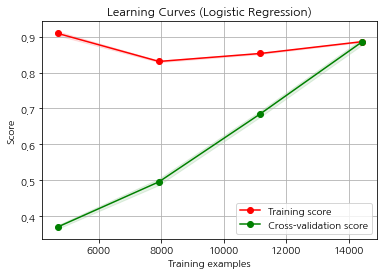

In [13]:
# 학습 곡선을 그리는 함수 정의
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 학습 곡선 그리기
title = "Learning Curves (Logistic Regression)"
# 모델은 이미 훈련되었다고 가정합니다 (model 변수에 저장되어 있음)
plot_learning_curve(model, title, X_train_resampled, Y_train_resampled, cv=5, n_jobs=1)

plt.show()

## 변수선택법
- p-value로 최종선택

In [14]:
# 선택된 변수들의 인덱스 명을 변경
selected_feature_names = ['Building_Age', 'JS_BA', 'LC_index', 'CA_index', 'HSP_index', 'Sell_Price', 'Region_Name_encoded']
selected_X_train_resampled = X_train_resampled[:, selected_feature_indices]
selected_X_train_resampled = pd.DataFrame(selected_X_train_resampled, columns=selected_feature_names)

model = sm.MNLogit(Y_train_resampled, sm.add_constant(selected_X_train_resampled))  # 상수항 추가

# 모델 피팅
result = model.fit()

# 독립 변수들의 p-value 추출
p_values = result.pvalues

# 결과 출력
print("P-values for selected independent variables:")
print(p_values)

         Current function value: 0.391668
         Iterations: 35
P-values for selected independent variables:
                                 0              1             2         3
const                9.989819e-302   0.000000e+00  5.954249e-56  0.999230
Building_Age          1.320765e-95  1.879968e-251  0.000000e+00  0.999520
JS_BA                6.804349e-178   0.000000e+00  0.000000e+00  0.999295
LC_index              1.598013e-22   3.764872e-01  7.626987e-19  0.999983
CA_index              1.845172e-12   1.590120e-04  8.198235e-02  0.999995
HSP_index             5.315791e-20   1.057882e-02  1.775289e-22  0.999892
Sell_Price           7.372045e-109  2.701897e-195  0.000000e+00  0.999026
Region_Name_encoded   2.761862e-50  2.453421e-152  1.455333e-32  0.999171


- a=0.05일 때, 클래스 3을 제외하고 p-value값을 고려하면 LC_index, CA_index를 제외한다.